In [1]:
import numpy as np
from numba import jit
exp=np.exp
def alpha_m (V):
    return  -0.025*(V+40.)/( exp(-(V+40)/10) - 1.0 )
def beta_m(V):
    return exp(-(V+65)/18)
def mNa_inf(V):
    return alpha_m(V) / (alpha_m(V) + beta_m(V))
def tau_mNa(V):
    return 1 / (alpha_m(V) + beta_m(V))/5
def alpha_h(V):
    return 0.0175*exp(-(V+65)/20)
def beta_h(V):
    return 0.25/(1.0 + exp(-(V+35)/10) )
def hNa_inf(V):
    return alpha_h(V) / (alpha_h(V) + beta_h(V))
def tau_hNa (V):
    return 1 / (alpha_h(V) + beta_h(V))/5
Kdshift=10.0

def alpha_mKd(V):
    return 0.0025*(V+55.)/(1. - exp(-(V+55.)/10.))
                           
beta_mKd = lambda V: 0.03125*exp(-(V+65.)/80.)
mKd_inf = lambda V: alpha_mKd(V-Kdshift) / (alpha_mKd(V-Kdshift) + beta_mKd(V-Kdshift))
tau_mKd = lambda V: 1 / (alpha_mKd(V-Kdshift) + beta_mKd(V-Kdshift))/5 

mA_inf = lambda V: 1/(1+exp(-(V+90)/8.5))
tau_mA = lambda V: 0.37 + 1/(exp((V+35.82)/19.697)+exp((V+79.69)/-12.7))/5 
hA_inf = lambda V: 1/(1+exp((V+78)/6))

def tau_hA(V): # Inactivation time-constant
    if (V < -63):
        tau_hA = 1/(exp((V+46.05)/5)+exp((V+238.4)/-37.45))
    else:
        tau_hA = 19
    return tau_hA/5

mKir_inf = lambda V: 1/(1+exp((V+97.9+10)/9.7))

# T-type Ca-current (mt=activation variable, ht=inactivation variable)
mt_inf = lambda V: 1/(1+exp(-(V+57)/6.2)) # Activation function
tau_mt = lambda V: 0.612 + 1/(exp(-(V+131.6)/16.7)+exp((V+16.8)/18.2)) # Activation time-constant
ht_inf = lambda V:1/(1+exp((V+81)/4.03)) # Inactivation function

def tau_ht(V): # Inactivation time-constant
    if (V < -80):
        tau_ht = exp((V+467)/66.6)
    else:
        tau_ht = (exp(-(V+21.88)/10.2)+28)
    return tau_ht


# L-type Ca-current (mL=activation variable)
mL_inf = lambda V:1/(1+exp(-(V+55.)/3)) # Activation function
tau_mL = lambda V: (72*exp(-(V+45.)**2/400)+6.) # Activation time-constant

# H-current (mH=activation variable)
alpha_mH = lambda V: exp(-14.59-(0.086*V))
beta_mH = lambda V: exp(-1.87+(0.0701*V))
mH_inf = lambda V: alpha_mH(V) /(alpha_mH(V) + beta_mH(V)) # Activation function
tau_mH = lambda V: 1/(alpha_mH(V) + beta_mH(V)) # Activation time-constant

In [2]:
heaviside =lambda t:(1+np.sign(t))/2 
pulse =lambda t,ti,tf : heaviside(t-ti)-heaviside(t-tf)
sin=np.sin
pi=np.pi
@jit
def HM_ODE(t,u):
    # Parameters
    Iapp=p[0] # Amplitude of constant applied current
    I1=p[1] # Amplitude of first step input
    I2=p[2] # Amplitude of second step input
    ti1=p[3] # Starting time of first step input
    tf1=p[4] # Ending time of first step input
    ti2=p[5] # Starting time of second step input
    tf2=p[6] # Ending time of second step input
    gKd=p[7]  # Delayed-rectifier potassium current maximal conductance
    gNa=p[8] # Sodium current maximal conductance
    gLeak=p[9] # Leak current maximal conductance
    C=p[10] # Membrane capacitance
    taunoise=p[11] # Cutoff frequency for low-pass filtered Gaussian noise
    Ain=p[12] # Amplitude of sinusoïdal inut
    Win=p[13] # Frequency of  sinusoïdal inut

    # Variables
    V=u[0] # Membrane potential
    mNa=u[1] # Sodium current activation
    hNa=u[2] # Sodium current inactivation
    mKd=u[3] # Delayed-rectifier potassium current activation
    noise=u[4] # Input noise

   
    
    # ODEs
    du1=1/C*(- gNa*mNa**3*hNa*(V-VNa) - gKd*mKd**4*(V-VK) - gLeak*(V-Vleak)+Iapp + I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2) + noise + Ain*sin(2*pi*Win*t)) # Voltage equation
    du2=1/tau_mNa(V)*(-mNa+mNa_inf(V)) # gating equation
    du3=1/tau_hNa(V)*(-hNa+hNa_inf(V))
    du4=1/tau_mKd(V)*(-mKd+mKd_inf(V))
    du5=-noise/taunoise # Noise equation
    
    return [du1,du2,du3,du4,du5]

In [3]:
def  OB_ODE(t,u):
    
    V=u[0] # Membrane potential
    mNa=u[1] # Sodium current activation
    hNa=u[2] # Sodium current inactivation
    mKd=u[3] # Delayed-rectifier potassium current activation
    Theta=np.array(u[4:10])#11
    A=np.array(u[10:16])#11:18
    P=np.array(u[16:52]).reshape([6,6])#18:67
    noise=u[52] # Input noise
    u_sys=u[53:58]
    obesV=u[53]
    
    
    Iapp=p[0] # Amplitude of constant applied current
    I1=p[1] # Amplitude of first step input
    I2=p[2] # Amplitude of second step input
    ti1=p[3] # Starting time of first step input
    tf1=p[4] # Ending time of first step input
    ti2=p[5] # Starting time of second step input
    tf2=p[6] # Ending time of second step input
    taunoise=p[11] # Cutoff frequency for low-pass filtered Gaussian noise
    Ain=p[12] # Amplitude of sinusoïdal inut
    Win=p[13] # Frequency of  sinusoïdal inut
    C=p[10]
    
    PHI0= -mNa**3*hNa*obesV
    PHI1= - gKd*mKd**4*obesV
    PHI2= -obesV
    PHI3= mNa**3*hNa
    PHI4= mKd**4
    PHI5= 1
    PHI6= Iapp + I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2)+ Ain*sin(2*pi*Win*t)
    
    PHI= np.array([PHI0,PHI1,PHI2,PHI3,PHI4,PHI5])
    
    #ODEs
    du1=1/C*(np.dot(PHI,Theta) + PHI6)+ gamma*(obesV-V)+gamma*np.dot(np.dot(A,P),A)*(obesV-V)# Voltage equation
    
    du2=1/tau_mNa(obesV)*(-mNa+mNa_inf(obesV)) # gating equation
    du3=1/tau_hNa(obesV)*(-hNa+hNa_inf(obesV))
    du4=1/tau_mKd(obesV)*(-mKd+mKd_inf(obesV))
    
    du5=gamma*np.dot(P,A)*(obesV-V)
    du6=-gamma*A+PHI
    du7=alpha*P-np.dot(np.dot(P,np.outer(A,A)),P)
    
    du8=-noise/taunoise # Noise equation
    
    du9=HM_ODE(t,u_sys)
    
    
    return([du1,du2,du3,du4,*du5.tolist(),*du6.tolist(),*du7.flatten().tolist(),du8,*du9])
    

In [4]:

def  OB2_ODE(t,u):
    
    V=u[0] # Membrane potential
    mNa=u[1] # Sodium current activation
    hNa=u[2] # Sodium current inactivation
    mKd=u[3] # Delayed-rectifier potassium current activation
    Theta=np.array(u[4:7])#11
    A=np.array(u[7:10])#11:18
    P=np.array(u[10:19]).reshape([3,3])#18:67
    noise=u[19] # Input noise
    u_sys=u[20:25]
    obesV=u[20]
    
    
    Iapp=p[0] # Amplitude of constant applied current
    I1=p[1] # Amplitude of first step input
    I2=p[2] # Amplitude of second step input
    ti1=p[3] # Starting time of first step input
    tf1=p[4] # Ending time of first step input
    ti2=p[5] # Starting time of second step input
    tf2=p[6] # Ending time of second step input
    taunoise=p[11] # Cutoff frequency for low-pass filtered Gaussian noise
    Ain=p[12] # Amplitude of sinusoïdal inut
    Win=p[13] # Frequency of  sinusoïdal inut
    C=p[10]
    
    PHI0= -mNa**3*hNa*(obesV-VNa)
    PHI1= - mKd**4*(obesV-VK)
    PHI2= -(obesV-Vleak)
    PHI3= Iapp + I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2)+ Ain*sin(2*pi*Win*t)
    
    PHI= np.array([PHI0,PHI1,PHI2])
    
    #ODEs
    du1=1/C*(np.dot(PHI,Theta) + PHI3)+ gamma*(obesV-V)+gamma*np.dot(np.dot(A,P),A)*(obesV-V)# Voltage equation
    
    du2=1/tau_mNa(obesV)*(-mNa+mNa_inf(obesV)) # gating equation
    du3=1/tau_hNa(obesV)*(-hNa+hNa_inf(obesV))
    du4=1/tau_mKd(obesV)*(-mKd+mKd_inf(obesV))
    
    du5=gamma*np.dot(P,A)*(obesV-V)
    du6=-gamma*A+PHI
    du7=alpha*P-np.dot(np.dot(P,np.outer(A,A)),P)
    
    du8=-noise/taunoise # Noise equation
    
    du9=HM_ODE(t,u_sys)
    
    
    return([du1,du2,du3,du4,*du5.tolist(),*du6.tolist(),*du7.flatten().tolist(),du8,*du9])

In [21]:
def  OB3_ODE(t,u):
    
    V=u[0] # Membrane potential
    mNa=u[1] # Sodium current activation
    hNa=u[2] # Sodium current inactivation
    mKd=u[3] # Delayed-rectifier potassium current activation
    Theta=np.array(u[4:7])#11
    A=np.array(u[7:10])#11:18
    P=np.array(u[10:19]).reshape([3,3])#18:67
    noise=u[19] # Input noise
    u_sys=u[20:25]
    obesV=u[20]
    
    
    Iapp=p[0] # Amplitude of constant applied current
    I1=p[1] # Amplitude of first step input
    I2=p[2] # Amplitude of second step input
    ti1=p[3] # Starting time of first step input
    tf1=p[4] # Ending time of first step input
    ti2=p[5] # Starting time of second step input
    tf2=p[6] # Ending time of second step input
    taunoise=p[11] # Cutoff frequency for low-pass filtered Gaussian noise
    Ain=p[12] # Amplitude of sinusoïdal inut
    Win=p[13] # Frequency of  sinusoïdal inut
    C=p[10]
    
    PHI0= -mNa**3*hNa*(obesV-VNa)
    PHI1= - mKd**4*(obesV-VK)
    PHI2= -(obesV-Vleak)
    PHI3= Iapp + I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2)+ Ain*sin(2*pi*Win*t)
    
    PHI= np.array([PHI0,PHI1,PHI2])
    
    Q=np.outer(PHI,PHI)
    
    #ODEs
    du1=1/C*(np.dot(PHI,Theta) + PHI3)+ gamma*(obesV-V)+gamma*np.dot(np.dot(A,P),A)*(obesV-V)# Voltage equation
    
    du2=1/tau_mNa(obesV)*(-mNa+mNa_inf(obesV)) # gating equation
    du3=1/tau_hNa(obesV)*(-hNa+hNa_inf(obesV))
    du4=1/tau_mKd(obesV)*(-mKd+mKd_inf(obesV))
    
    du5=gamma*np.dot(P,A)*(obesV-V)
    
    Theta_=Theta+du5
    mask=(np.sign(Theta_)+1)/2
    
    du5=mask*du5
    
    du6=-gamma*A+PHI
    du7=alpha*P-np.dot(np.dot(P,np.outer(A,A)),P)
    
    du8=-noise/taunoise # Noise equation
    
    du9=HM_ODE(t,u_sys)
    
    
    return([du1,du2,du3,du4,*du5.tolist(),*du6.tolist(),*du7.flatten().tolist(),du8,*du9])

In [5]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
## Simulation of the model in current-clamp mode HH model

## Definition of reversal potential values. 
VNa =45; # Sodium reversal potential 45
VCa = 120.; # Calcium reversal potential
VK = -90.; # Potassium reversal potential -90
Vleak = -55.; # Reversal potential of leak channels

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance

gNa=120.; # Sodium current maximal conductance 120
gKd=30; # Delayed-rectifier potassium current maximal conductance 80

## Definition of simulation time.
Tfinal=100
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=2.5

# Current pulses
I1=0. # Amplitude of first pulse
ti1=100 # Starting time of first pulse
tf1=103 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=200 # Starting time of second pulse
tf2=203 # Ending time of first pulse

# Sinusoidal input
Ain=0.0 # Amplitude
Win=0.0 # Frequency

# Input noise
NoiseIN=0. # Amplitude
TauNoise=2.0 # Cut-off frequency

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gKd,gNa,gLeak,C,TauNoise,Ain,Win]
#p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,C,NoiseIN,TauNoise,Ain,Win]

# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0), mKd_inf(V0), 0.0]
#x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), 0.0]


<ipython-input-2-6738bda99654>:5: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "HM_ODE" failed type inference due to: Untyped global name 'pulse': cannot determine Numba type of <class 'function'>

File "<ipython-input-2-6738bda99654>", line 33:
def HM_ODE(t,u):
    <source elided>
    # ODEs
    du1=1/C*(- gNa*mNa**3*hNa*(V-VNa) - gKd*mKd**4*(V-VK) - gLeak*(V-Vleak)+Iapp + I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2) + noise + Ain*sin(2*pi*Win*t)) # Voltage equation
    ^

  @jit
C:\Users\lenovo\anaconda3\lib\site-packages\numba\object_mode_passes.py:178: NumbaWarning: Function "HM_ODE" was compiled in object mode without forceobj=True.

File "<ipython-input-2-6738bda99654>", line 6:
@jit
def HM_ODE(t,u):
^

  state.func_ir.loc))
C:\Users\lenovo\anaconda3\lib\site-packages\numba\object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this

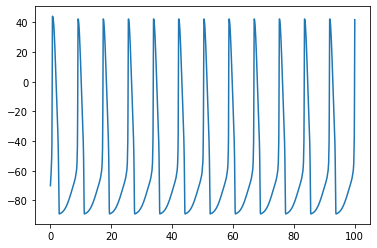

In [6]:
sol=solve_ivp(HM_ODE ,tspan , x0)
plt.plot(sol.t, sol.y[0])

In [7]:
## Simulation of the model in current-clamp mode HH model

## Definition of reversal potential values. 
VNa =45; # Sodium reversal potential 45
VCa = 120.; # Calcium reversal potential
VK = -90.; # Potassium reversal potential -90
Vleak = -55.; # Reversal potential of leak channels

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance

gNa=120.; # Sodium current maximal conductance 120
gKd=30; # Delayed-rectifier potassium current maximal conductance 80

## Definition of simulation time.
Tfinal=60
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=2.5

# Current pulses
I1=0. # Amplitude of first pulse
ti1=100 # Starting time of first pulse
tf1=103 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=200 # Starting time of second pulse
tf2=203 # Ending time of first pulse
gamma=5
alpha=0.5

# Sinusoidal input
Ain=0.0 # Amplitude
Win=0.0 # Frequency

# Input noise
NoiseIN=0. # Amplitude
TauNoise=2.0 # Cut-off frequency

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gKd,gNa,gLeak,C,TauNoise,Ain,Win]
#p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,C,NoiseIN,TauNoise,Ain,Win]

# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0), mKd_inf(V0), 0.0]
#x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), 0.0]

Theta0=(np.array([20,20,1,1,-1,-1])).tolist()
A0=np.array([0.1,0.1,0.1,0.1,0.1,1]).tolist()
P0=(np.ones([6,6])/100).flatten().tolist()
X0_=[V0,mNa_inf(V0),hNa_inf(V0), mKd_inf(V0),*Theta0,*A0,*P0,0.0,*x0]
print(len(X0_))



58


C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:23: Runtim

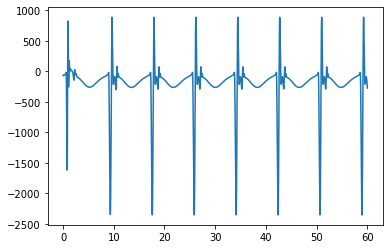

In [257]:
sol=solve_ivp(OB_ODE ,tspan , X0_)
plt.plot(sol.t, sol.y[0])

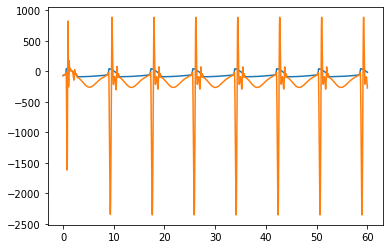

In [258]:
plt.plot(sol.t, sol.y[53])
plt.plot(sol.t, sol.y[0])

[100.          99.99919743  99.81285968 ...  79.80477805  79.95331389
  80.02170878]


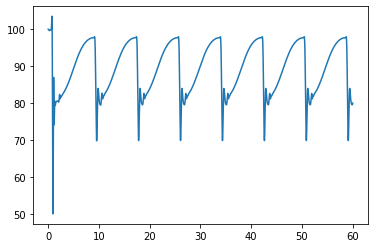

In [259]:
plt.plot(sol.t,sol.y[4])
print(sol.y[4])

In [24]:
## Simulation of the model in current-clamp mode HH model

## Definition of reversal potential values. 
VNa =45; # Sodium reversal potential 45
VCa = 120.; # Calcium reversal potential
VK = -90.; # Potassium reversal potential -90
Vleak = -55.; # Reversal potential of leak channels

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance

gNa=120.; # Sodium current maximal conductance 120
gKd=30; # Delayed-rectifier potassium current maximal conductance 80

## Definition of simulation time.
Tfinal=60
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=2.5

# Current pulses
I1=0. # Amplitude of first pulse
ti1=100 # Starting time of first pulse
tf1=103 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=200 # Starting time of second pulse
tf2=203 # Ending time of first pulse
gamma=5
alpha=0.5

# Sinusoidal input
Ain=0.0 # Amplitude
Win=0.0 # Frequency

# Input noise
NoiseIN=0. # Amplitude
TauNoise=2.0 # Cut-off frequency

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gKd,gNa,gLeak,C,TauNoise,Ain,Win]
#p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,C,NoiseIN,TauNoise,Ain,Win]

# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0), mKd_inf(V0), 0.0]
#x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), 0.0]

Theta0=(np.array([20,20,20])).tolist()
A0=np.array([0.1,0.1,0.1]).tolist()
P0=(np.identity(3)).flatten().tolist()
X0_=[V0,mNa_inf(V0),hNa_inf(V0), mKd_inf(V0),*Theta0,*A0,*P0,0.0,*x0]
print(len(X0_))

25


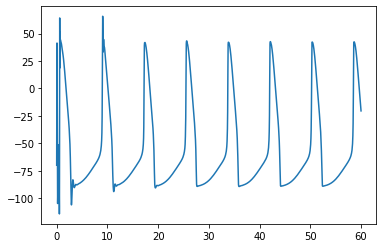

In [26]:
sol=solve_ivp(OB2_ODE ,tspan , X0_, 'BDF')
plt.plot(sol.t, sol.y[0])

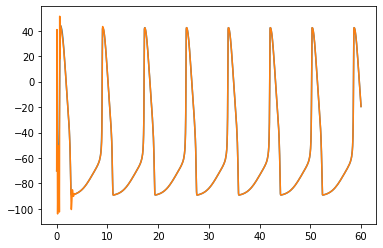

In [18]:
plt.plot(sol.t, sol.y[20])
plt.plot(sol.t, sol.y[0])

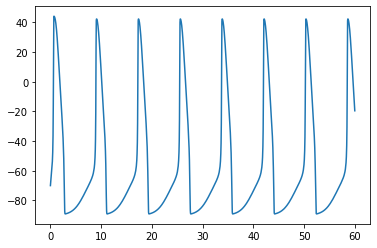

In [19]:
plt.plot(sol.t, sol.y[20])

[1.20013041e+02 3.00029725e+01 1.00099001e-01]


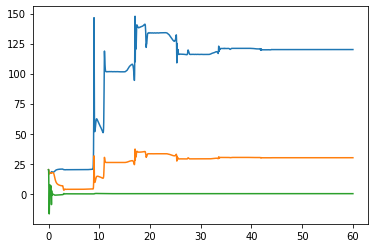

In [20]:
plt.plot(sol.t,sol.y[4])
plt.plot(sol.t,sol.y[5])
plt.plot(sol.t,sol.y[6])
print(sol.y[4:7,-1])

In [264]:
a=np.array([[1,2],[3,4],[5,6]])
b=np.array([1,1])
print(a.flatten())
print(a.flatten().reshape([3,2]))

[1 2 3 4 5 6]
[[1 2]
 [3 4]
 [5 6]]


In [36]:
a=np.array([1,2,3,4,5,6])
a[0:2]=np.array([[0,0]])
print(a)

[0 0 3 4 5 6]
